In [3]:
import cv2
import clip
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from segment_anything import build_sam, SamAutomaticMaskGenerator
root_dir = "C:\\Users\\Lenovo\\Desktop\\assemblyhelper"

In [4]:
# Download the model weights to load them here
device = "cuda"
checkpoint_path = "thirdparty/SAM-webui/sam_vit_h_4b8939.pth"
sam = build_sam(checkpoint=os.path.abspath(os.path.join(root_dir, checkpoint_path))).to(device)
mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=64, pred_iou_thresh=0.98, crop_n_layers=0)

In [5]:
# process images
# image_path = "assets/assembly/bottom_left.jpg"
# image_path = "assets/assembly/bottom_right.jpg"
# image_path = "assets/assembly/center.jpg"
# image_path = "assets/assembly/right.jpg"
# image_path = "assets/assembly/top_left.jpg"
# image_path = "assets/assembly/top_right.jpg"

# image_path = "assets/assembly2/bottom_left.jpg"
# image_path = "assets/assembly2/bottom_right.jpg"
# image_path = "assets/assembly2/center.jpg"
# image_path = "assets/assembly2/right.jpg"
# image_path = "assets/assembly2/top_left.jpg"
# image_path = "assets/assembly2/top_right.jpg"

# image_path = "assets/assembly_pipline/none.jpg"
# image_path = "assets/assembly_pipline/none2.jpg"
# image_path = "assets/assembly_pipline/step_battery.jpg"
# image_path = "assets/assembly_pipline/step_signal.jpg"
# image_path = "assets/assembly_pipline/step_stringer1.jpg"
# image_path = "assets/assembly_pipline/step_stringer2.jpg"
# image_path = "assets/assembly_pipline/step_stringer3.jpg"
# image_path = "assets/assembly_pipline/step_stringer4.jpg"

# image_path = "assets/parts/parts_1.jpg"
# image_path = "assets/parts/parts_2.jpg"
# image_path = "assets/parts/parts_3.jpg"
# image_path = "assets/parts/parts_4.jpg"
# image_path = "assets/parts/parts_5.jpg"
# image_path = "assets/parts/parts_6.jpg"

# image_path = "assets/exp_data/images/assembly_space1.jpg"
# image_path = "assets/exp_data/images/assembly_space2.jpg"
# image_path = "assets/exp_data/images/assembly_space3.jpg"
# image_path = "assets/exp_data/images/assembly_space4.jpg"
# image_path = "assets/exp_data/images/assembly_space5.jpg"
# image_path = "assets/exp_data/images/assembly_space6.jpg"
# image_path = "assets/exp_data/images/part_space1.jpg"
# image_path = "assets/exp_data/images/part_space2.jpg"
# image_path = "assets/exp_data/images/part_space3.jpg"
# image_path = "assets/exp_data/images/part_space4.jpg"
# image_path = "assets/exp_data/images/part_space5.jpg"
# image_path = "assets/exp_data/images/part_space6.jpg"
image_path = "assets/exp_data/images/tool_space1.jpg"
# image_path = "assets/exp_data/images/tool_space2.jpg"
# image_path = "assets/exp_data/images/tool_space3.jpg"


# image_path = "assets/exp_data/7.jpg"   # bad results, maybe background
image_path = os.path.abspath(os.path.join(root_dir, image_path))

In [6]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)

In [7]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [int(x1), int(y1), int(x2), int(y2)]

In [8]:
def segment_image(image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]  
    black_image = np.zeros_like(image_array)
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    black_image[segmentation_mask] = segmented_image_array[segmentation_mask]
    return black_image

In [9]:
def pad_to_square(input_image, fill_color=(0, 0, 0)):
    height, width, _ = input_image.shape
    new_size = max(width, height)
    new_image = np.full((new_size, new_size, 3), fill_color, dtype=np.uint8)
    left = (new_size - width) // 2
    top = (new_size - height) // 2
    new_image[top:top+height, left:left+width] = input_image
    return new_image

In [10]:
# Cut out all masks
cropped_boxes = []
for mask in masks:
    x1, y1, x2, y2 = convert_box_xywh_to_xyxy(mask["bbox"])
    # print(x1, y1, x2, y2)
    cropped_boxes.append(pad_to_square(segment_image(image, mask["segmentation"])[y1:y2, x1:x2]))

In [11]:
# Load CLIP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

In [12]:
# Load label
label_dir = "dataset/dataset_final/trainset"
label_names = os.listdir(os.path.abspath(os.path.join(root_dir, label_dir)))

transform_matrixes = []
transform_features = []
for ln in label_names:
    label = np.load(os.path.abspath(os.path.join(root_dir, label_dir, ln, "label_256.npy")), allow_pickle=True)
    transform_feature = label[()]['feature_pca']
    transform_matrix = label[()]['trans_pca']
    transform_feature /= np.linalg.norm(transform_feature, axis=-1)
    transform_features.append(transform_feature)
    transform_matrixes.append(transform_matrix)
#     transform_features.append(torch.tensor(transform_feature))
#     transform_matrixes.append(torch.tensor(transform_matrix))

# Calculate similarity
with torch.no_grad():
    def retriev(elements, transform_matrixes, transform_features) -> int:
        # process imgs
        preprocessed_images = [preprocess(Image.fromarray(image)).to(device) for image in elements]
        stacked_images = torch.stack(preprocessed_images)
        image_features = model.encode_image(stacked_images).detach()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarities = []
        for matrix, feature in zip(transform_matrixes, transform_features):
            transformed_feature = image_features.cpu().numpy() @ matrix.T
            transformed_feature /= np.linalg.norm(transformed_feature, axis=-1, keepdims=True)
            similarity = transformed_feature @ feature[:, np.newaxis]
            similarities.append(similarity)
        similarities = np.concatenate(similarities, axis=1)
        preds = np.argmax(similarities, axis=1)
        return similarities

In [13]:
def get_indices_of_values_above_threshold(values, threshold):
    preds = [-1] * values.shape[0]
    for i, v in enumerate(values):
        if np.max(v)<threshold:
            continue
        pred = int(np.argmax(v))
        preds[i] = pred
    return preds

In [14]:
def calculate_overlap_ratio(image1, image2):
    # calculate overlap areas
    intersection = np.logical_and(image1, image2)
    intersection_area = np.sum(intersection)
    # calculate these two images' areas
    total_area_image1 = np.sum(image1)
    total_area_image2 = np.sum(image2)
    # calculate overlap ratio
    overlap_ratio = intersection_area / min(total_area_image1, total_area_image2)
    return overlap_ratio

In [15]:
# Get overlap pairs
def get_overlap_pairs():
    overlap_pairs = []
    overlap_ratios = []
    for i in range(len(masks)):
        for j in range(i+1, len(masks)):
            image1 = masks[i]["segmentation"]
            image2 = masks[j]["segmentation"]
            overlap_ratio = calculate_overlap_ratio(image1, image2)
            if overlap_ratio > 0.5:
                overing = i if np.sum(image1) > np.sum(image2) else j
                overed = i if np.sum(image1) < np.sum(image2) else j
                overlap_pairs.append([overing, overed])
                overlap_ratios.append(overlap_ratio)
    return overlap_pairs
    # print(overlap_pairs)            

In [16]:
# Filter background
def get_background_indices():
    bkgd_indices = []
    for i in range(len(masks)):    
        im = masks[i]["segmentation"]
        top_left = im[0:50, 0:50]
        top_right = im[0:50, -50:]
        bottom_left = im[-50:, :50]
        bottom_right = im[-50:, -50:]
        background = np.sum(bottom_right) + np.sum(top_right) + np.sum(bottom_left)
        # print(np.sum(bottom_left))
        if background >= 1500:
            bkgd_indices.append(i)
    return bkgd_indices

In [17]:
# Filter smaller
def get_small_indices():
    small_indices = []
    for i in range(len(masks)):
        im = masks[i]["segmentation"]
        if np.sum(im) < 1500:
            small_indices.append(i)
    return small_indices

1 橘 hex 0.9841087945188891
3 蓝 slotted 0.9799212193423118


True

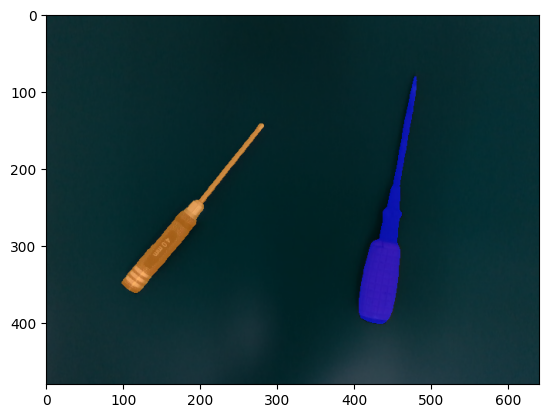

In [51]:
scores = retriev(cropped_boxes, transform_matrixes, transform_features)
# threshold is set as 0.9
indices = get_indices_of_values_above_threshold(scores, 0.9)

filter_idxs = []
bkgd_indices = get_background_indices()
overlap_pairs = get_overlap_pairs()
small_indices = get_small_indices()
for idx in small_indices:
    filter_idxs.append(idx)
for idx in bkgd_indices:
    filter_idxs.append(idx)
for idx, (overing, overed) in enumerate(overlap_pairs):
    # if mask's area is too small, it probably is oversegmented fragment. So, we don't consider overlapping relationship with this mask.
    if overed in small_indices:
        continue
    pred_ind = np.argmax(scores[overing])
    pred_overing_name = label_names[pred_ind]
    pred_ind = np.argmax(scores[overed])
    pred_overed_name = label_names[pred_ind]
    # for stringer, we filter overing mask, because two stringers sometimes segments as one.
    if pred_overed_name == 'stringer' and pred_overing_name == 'stringer':
        # Here, it is better to determine the overing stringer's area
        # if overing stringer is too big, filter overing (because two stringer make too big mask), overwise, 
        # filter overed (because this situation means the stringer is oversegmented)
        filter_idxs.append(overing)
    else:
        filter_idxs.append(overed)
    
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

alpha = 0.6
overlay_image = np.zeros_like(original_image, dtype=np.uint8)
color_map = ["红", "黄", "粉", "橘", "绿", "青", "蓝", "肖贡土色", "土耳其蓝"]
overlay_color_map = [
    (255, 0, 0),  # 红色
    (255, 255, 0),  # 黄
    (255,0,255),  # 粉红
    (255,128,0),  # 橘黄
    (0,255,0),  # 绿色
    (0,255,255),  # 青色
    (0,0,255),  # 蓝色
    (160,32,240),  # 肖贡土色
    (0,199,140),  # 土耳其蓝
]

labeled_idx = []
for seg_idx, value in enumerate(indices):
    if seg_idx in filter_idxs:
        continue
    if value == -1:
        continue
    # if seg_idx in [6]:
    #     continue
    segmentation_mask = masks[seg_idx]["segmentation"]
    overlay_image[segmentation_mask] = overlay_color_map[value]
    print(seg_idx, color_map[value], label_names[value], scores[seg_idx][value])
    labeled_idx.append([seg_idx, color_map[value], label_names[value], scores[seg_idx][value]])
    
result_image = cv2.addWeighted(original_image, 1 - alpha, overlay_image, alpha, 0)
plt.imshow(result_image)
# plt.imshow(overlay_image)


# result_save_path = "assets/exp_data/results/mask_part4_1.jpg"
# overlay_save_path = "assets/exp_data/results/mask_part4_2.jpg"

# result_save_path = "assets/exp_data/results/mask_assembly6_1.jpg"
# overlay_save_path = "assets/exp_data/results/mask_assembly6_2.jpg"

result_save_path = "assets/exp_data/results/mask_tools1_1.jpg"
overlay_save_path = "assets/exp_data/results/mask_tools1 _2.jpg"

cv2.imwrite(os.path.join(root_dir, result_save_path), cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))
cv2.imwrite(os.path.join(root_dir, overlay_save_path), cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR))

True

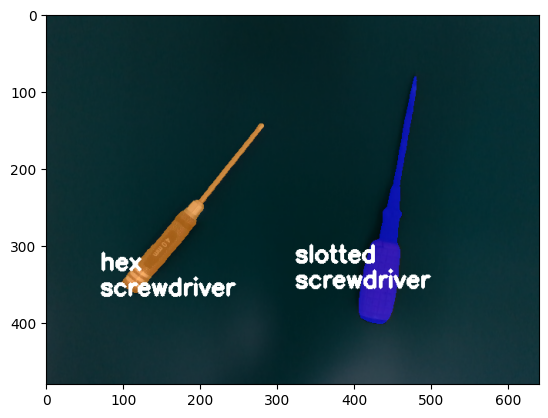

In [52]:
binary_image = masks[3]["segmentation"]
# binary_image

# get mask's center
for ld in labeled_idx:
    seg_idx = ld[0]
    # if seg_idx in [5]:
    #     continue
    label_name = ld[2]
    y, x = np.where(masks[seg_idx]["segmentation"])
    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    cX, cY = int(1/2 * (xmin + xmax)), int(1/2 * (ymin + ymax))
    
    if label_name == "warehouse":
        cY -= 200
    if label_name == "signalinterfaceboard":
        label_name = "signalboard"
        cY += 50
    if label_name == "stringer":
        cX -= 50
    if label_name == "framework":
        cX -=80
        cY +=100
    if label_name in ["hex", "slotted", "phillips"]:
        cX -=120
        cY +=80
        cv2.putText(result_image, "screwdriver", (cX, cY+33), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 3)
 
        
    cv2.putText(result_image, f"{label_name}", (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 3)
plt.imshow(result_image)

# mask_save_path = "assets/exp_data/results/mask_part4_3.jpg"
# mask_save_path = "assets/exp_data/results/mask_assembly6_3.jpg"
mask_save_path = "assets/exp_data/results/mask_tools1_3.jpg"
cv2.imwrite(os.path.join(root_dir, mask_save_path), cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))

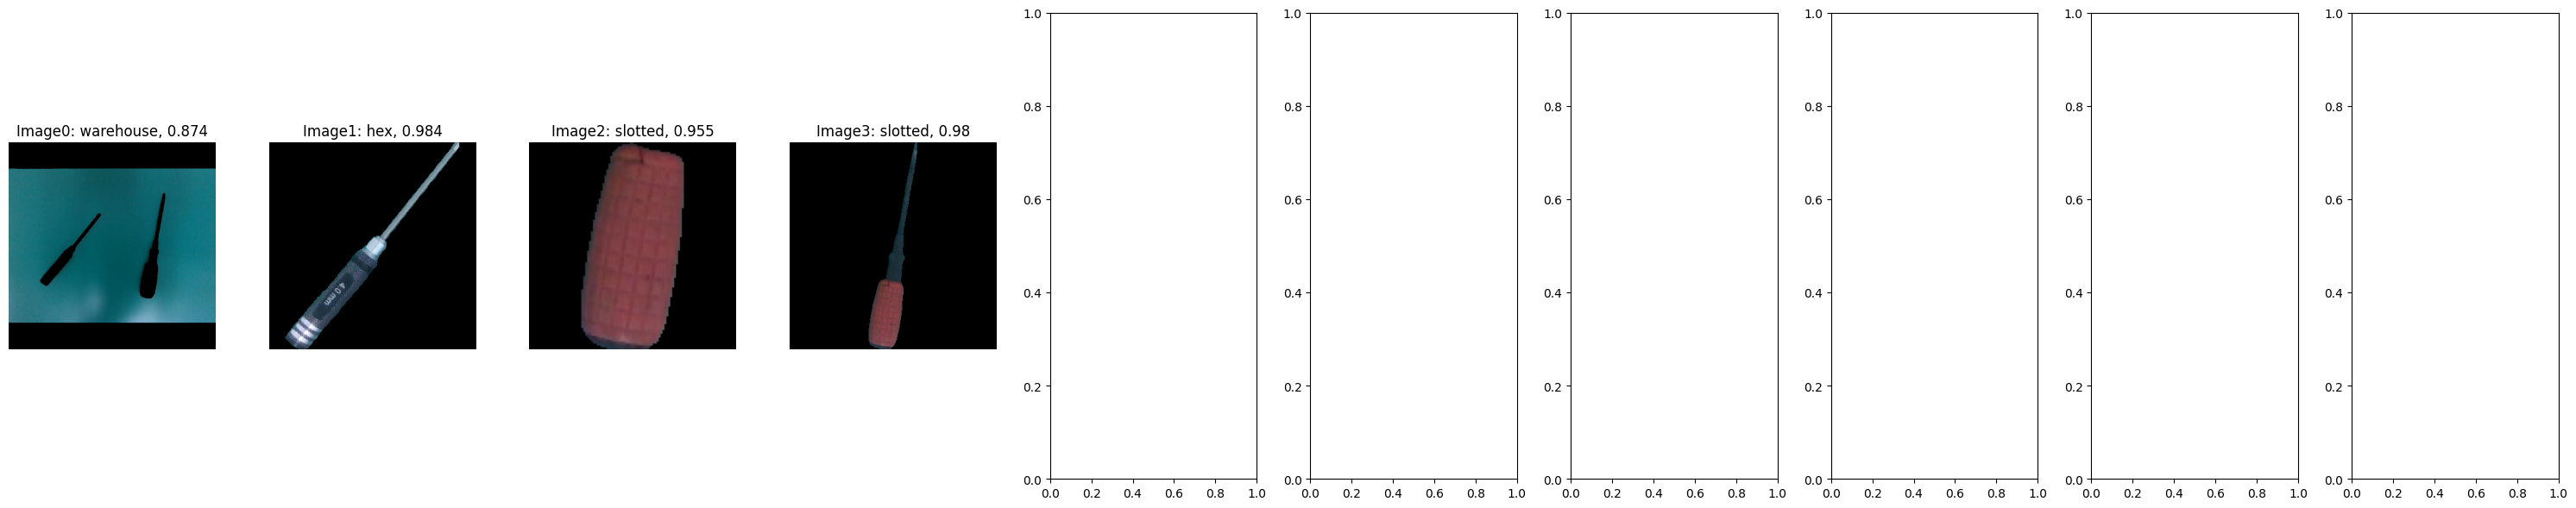

In [20]:
columns = 10
rows = len(cropped_boxes) // columns + 1
fig, axes = plt.subplots(rows, columns, figsize=(30, 6))
ax = axes.ravel()
for idx, crop in enumerate(cropped_boxes):
    ax[idx].imshow(crop)
    ax[idx].axis('off')
    sim = "{:.3g}".format(scores[idx][indices[idx]])
    if label_names[indices[idx]] == 'signalinterfaceboard':
        title = 'signal'
    else:
        title = label_names[indices[idx]]
    ax[idx].set_title(f"Image{idx}: {title}, {sim}")
plt.tight_layout()
plt.show()

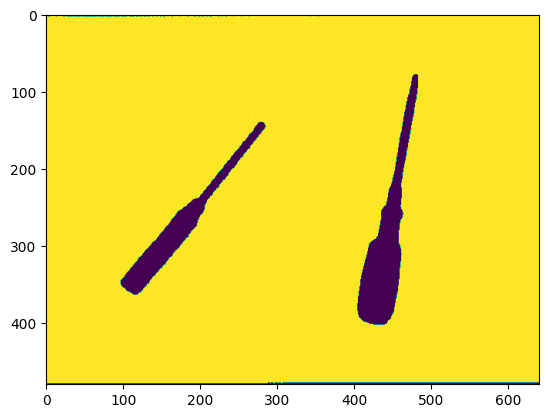

In [21]:
plt.imshow(masks[0]["segmentation"])

In [20]:
# save_path = "assets/exp_data/masks/part_space4.npy"
# mask_info = {}
# # mask_info['stringer1'] = masks[2]["segmentation"]
# # mask_info['stringer2'] = masks[8]["segmentation"]
# mask_info['stringer3'] = masks[2]["segmentation"]
# mask_info['stringer4'] = masks[11]["segmentation"]
# mask_info['signal'] = masks[6]["segmentation"]
# # mask_info['battery'] = masks[0]["segmentation"]

# np.save(os.path.join(root_dir, save_path), mask_info)

In [86]:
save_path = "assets/exp_data/masks/tool_space1.npy"
mask_info = {}
# mask_info['phillips'] = masks[2]["segmentation"]
mask_info['hex'] = masks[1]["segmentation"]
mask_info['slotted'] = masks[3]["segmentation"]
# mask_info['battery'] = masks[0]["segmentation"]

np.save(os.path.join(root_dir, save_path), mask_info)